## Figure 3

* Plot all points of the different roots as seperate peridograms
* Check fourier transform of each different root
* Compare the peaks of the different roots

** Cut the signal in 24 hour chunks and do the periodogram on that for
     ** Individual roots
     ** cut/uncut groups
     
** Justify the prominence 
** Interpolate the std



### Initialize python

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import detrend
from scipy.fftpack import fft
from scipy.fftpack import fftfreq
from scipy.fftpack import fftshift
from sklearn import preprocessing
import scipy.stats as stats
import statsmodels.api as sm
from scipy.interpolate import interp1d
import scipy as sp
plt.style.use('seaborn-white')
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.signal import find_peaks
import math
import scipy.special as sc
import random
import copy

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


 ## Load data

In [2]:
#input_path = 'working/fallest/Imperial Project/data_for_figures/'  ##change this to the path where the data is saved
input_path = 'C:\\Users\\fallest\\Google Drive\\Imperial Paper\\data\\'

Root_142 = pd.read_csv(input_path+'142_lifematrix_clean_feb1.txt')
Root_147 = pd.read_csv(input_path+'147_lifematrix_clean_feb1.txt')
Root_182 = pd.read_csv(input_path+'182_lifematrix_clean_feb1.txt')
Root_192 = pd.read_csv(input_path+'192_lifematrix_clean_feb1.txt')
Root_200 = pd.read_csv(input_path+'200_lifematrix_clean_feb1.txt')
Root_208 = pd.read_csv(input_path+'208_lifematrix_clean_feb1.txt')
Root_218 = pd.read_csv(input_path+'218_lifematrix_clean_feb1.txt')
Root_219 = pd.read_csv(input_path+'219_lifematrix_clean_feb1.txt')

In [3]:
# Added index for each cut root
Root_182.columns=np.arange(1,len(Root_182.loc[0])+1)
Root_192.columns=np.arange(1,len(Root_192.loc[0])+1)
Root_200.columns=np.arange(1,len(Root_200.loc[0])+1)
Root_208.columns=np.arange(1,len(Root_208.loc[0])+1)

# Added index for each uncut root
Root_142.columns=np.arange(1,len(Root_142.loc[0])+1)
Root_147.columns=np.arange(1,len(Root_147.loc[0])+1)
Root_218.columns=np.arange(1,len(Root_218.loc[0])+1)
Root_219.columns=np.arange(1,len(Root_219.loc[0])+1)

In [4]:
# Generate timeseries of event for each cut root from life-matrix
Timeseries_root_182=Root_182.sum(axis=1, skipna=False)
Timeseries_root_192=Root_192.sum(axis=1, skipna=False)
Timeseries_root_200=Root_200.sum(axis=1, skipna=False)
Timeseries_root_208=Root_208.sum(axis=1, skipna=False)

# Generate timeseries of event for each uncut root from life-matrix
Timeseries_root_142=Root_142.sum(axis=1, skipna=False)
Timeseries_root_147=Root_147.sum(axis=1, skipna=False)
Timeseries_root_218=Root_218.sum(axis=1, skipna=False)
Timeseries_root_219=Root_219.sum(axis=1, skipna=False)

#keep one we don't screw with
test_182 = copy.deepcopy(Timeseries_root_182)

## Clean the data for frames with far too many divisions

In [5]:
## this function is the main difference between what I did and what the boys did.  
# This function:
#1.) drops the NaN's
#2.) Finds the 90th percentile of the data
#3.) Finds the standard deviation
#4.) Multiplies the standard deviation by 5, and adds that to the 90th percentile, to get "Upper_bound"
#5.) Converts any frames with too many divisions (i.e. critera above) and turns them into NaN.  See "Figure_4_Broken_Frame_Check.ipynb"


def Filter_for_bad_frame(Timeseries_of_individual_root,Number_of_std_away,Quantile):
    
  Timeseries_of_individual_root_withoutNaN=Timeseries_of_individual_root.dropna() #drop the NaNs
  Quantile_of_data=np.percentile(Timeseries_of_individual_root_withoutNaN,Quantile) #find the qth percetile of data
  Upper_bound=Quantile_of_data+Number_of_std_away*np.std(Timeseries_of_individual_root_withoutNaN)
  Frame_remained=Timeseries_of_individual_root<=Upper_bound
  Frame_removed=Timeseries_of_individual_root[Frame_remained==False]
  Timeseries_of_individual_root[Frame_remained==False]=np.nan
  if Frame_removed.size==0:
    print ('No broken frame in this root')
  return Timeseries_of_individual_root,Frame_removed

In [6]:
#Cut roots
Timeseries_root_182,Frame_removed_182=Filter_for_bad_frame(Timeseries_root_182,5,90)
Timeseries_root_192,Frame_removed_192=Filter_for_bad_frame(Timeseries_root_192,5,90)
Timeseries_root_200,Frame_removed_200=Filter_for_bad_frame(Timeseries_root_200,5,90)
Timeseries_root_208,Frame_removed_208=Filter_for_bad_frame(Timeseries_root_208,5,90)

# Uncut roots
Timeseries_root_142,Frame_removed_142=Filter_for_bad_frame(Timeseries_root_142,5,90)
Timeseries_root_147,Frame_removed_147=Filter_for_bad_frame(Timeseries_root_147,5,90)
Timeseries_root_218,Frame_removed_218=Filter_for_bad_frame(Timeseries_root_218,5,90)
Timeseries_root_219,Frame_removed_219=Filter_for_bad_frame(Timeseries_root_219,5,90)

## Where do these broken frames come from?? Are they NaN's or are they something else? 

In [7]:
#Added march 25, 2021.  The boys are finding a lot of broken frames.  I think they might have had this wrong, 
# but Giovanni likes the boys results, so I'll have to write some parallel code.

print('Root 182 had: ', Frame_removed_182.size, ' broken frames')
print('Root 192 had: ', Frame_removed_192.size, ' broken frames')
print('Root 200 had: ', Frame_removed_200.size, ' broken frames')
print('Root 208 had: ', Frame_removed_208.size, ' broken frames')
print('Root 142 had: ', Frame_removed_142.size, ' broken frames')
print('Root 147 had: ', Frame_removed_147.size, ' broken frames')
print('Root 218 had: ', Frame_removed_218.size, ' broken frames')
print('Root 219 had: ', Frame_removed_219.size, ' broken frames')

Root 182 had:  58  broken frames
Root 192 had:  126  broken frames
Root 200 had:  50  broken frames
Root 208 had:  56  broken frames
Root 142 had:  19  broken frames
Root 147 had:  6  broken frames
Root 218 had:  186  broken frames
Root 219 had:  6  broken frames


### Interpolate roots and round the number of divisions

In [8]:
# Cut Root 

#Timeseries_root_182,Frame_removed_182=Filter_for_bad_frame(Timeseries_root_182,5,90)
Timeseries_root_182=Timeseries_root_182.interpolate(method ='linear', limit_direction ='both', limit = 5)

#Timeseries_root_192,Frame_removed_192=Filter_for_bad_frame(Timeseries_root_192,5,90)
Timeseries_root_192=Timeseries_root_192.interpolate(method ='linear', limit_direction ='both', limit = 5)

#Timeseries_root_200,Frame_removed_200=Filter_for_bad_frame(Timeseries_root_200,5,90)
Timeseries_root_200=Timeseries_root_200.interpolate(method ='linear', limit_direction ='both', limit = 5)

#Timeseries_root_208,Frame_removed_208=Filter_for_bad_frame(Timeseries_root_208,5,90)
Timeseries_root_208=Timeseries_root_208.interpolate(method ='linear', limit_direction ='both', limit = 5)

# Uncut root

#Timeseries_root_142,Frame_removed_142=Filter_for_bad_frame(Timeseries_root_142,5,90)
Timeseries_root_142=Timeseries_root_142.interpolate(method ='linear', limit_direction ='both', limit = 5)

#Timeseries_root_147,Frame_removed_147=Filter_for_bad_frame(Timeseries_root_147,5,90)
Timeseries_root_147=Timeseries_root_147.interpolate(method ='linear', limit_direction ='both', limit = 5)

#Timeseries_root_218,Frame_removed_218=Filter_for_bad_frame(Timeseries_root_218,5,90)
Timeseries_root_218=Timeseries_root_218.interpolate(method ='linear', limit_direction ='both', limit = 5)

#Timeseries_root_219,Frame_removed_219=Filter_for_bad_frame(Timeseries_root_219,5,90)
Timeseries_root_219=Timeseries_root_219.interpolate(method ='linear', limit_direction ='both', limit = 5)

In [9]:
#the time series have fractional blobs in them, which can't really happen.  These need to be rounded
Timeseries_root_142 = round(Timeseries_root_142)
Timeseries_root_147 = round(Timeseries_root_147)
Timeseries_root_218 = round(Timeseries_root_218)
Timeseries_root_219 = round(Timeseries_root_219)

Timeseries_root_182 = round(Timeseries_root_182)
Timeseries_root_192 = round(Timeseries_root_192)
Timeseries_root_200 = round(Timeseries_root_200)
Timeseries_root_208 = round(Timeseries_root_208)

### Export pre-processed data if desired

In [10]:
##export Gunnar ready files, change to True if you want to export files
##uncut  = 142, 147, 218, 219
##cut = 182, 192, 200, 208

export = False
output_path =input_path + 'data_out\\'

print(output_path)

import os
if export == True:
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    #uncut
    Timeseries_root_142.to_csv(output_path+'Timeseries_root_142.csv')
    Timeseries_root_147.to_csv(output_path+'Timeseries_root_147.csv')
    Timeseries_root_218.to_csv(output_path+'Timeseries_root_218.csv')
    Timeseries_root_219.to_csv(output_path+'Timeseries_root_219.csv')

    #cut
    Timeseries_root_182.to_csv(output_path+'Timeseries_root_182.csv')
    Timeseries_root_192.to_csv(output_path+'Timeseries_root_192.csv')
    Timeseries_root_200.to_csv(output_path+'Timeseries_root_200.csv')
    Timeseries_root_208.to_csv(output_path+'Timeseries_root_208.csv')

C:\Users\fallest\Google Drive\Imperial Paper\data\data_out\


In [11]:
##now group the data
uncut_raw_df = pd.DataFrame(
{
    "Root_142":Timeseries_root_142,
    "Root_147":Timeseries_root_147,
    "Root_218":Timeseries_root_218,
    "Root_219":Timeseries_root_219,
    
})

cut_raw_df = pd.DataFrame(
{
    "Root_182":Timeseries_root_182,
    "Root_192":Timeseries_root_192,
    "Root_200":Timeseries_root_200,
    "Root_208":Timeseries_root_208,
    
})

##write them out
if export == True:
    uncut_raw_df.to_csv(output_path+'uncut_raw_df.csv')
    cut_raw_df.to_csv(output_path+'cut_raw_df.csv')

# Make spectral density table for each root

In [12]:
# Make the periodograms for each root, using a rolling average of 3
roll_ave = 3

Root_frequency_all_182, Spectral_density_all_182 =sp.signal.periodogram(Timeseries_root_182[0:444].rolling(roll_ave, min_periods=1).mean(), fs=0.0011111,detrend='linear',scaling='spectrum')

Root_frequency_all_192, Spectral_density_all_192=sp.signal.periodogram(Timeseries_root_192[0:372].rolling(roll_ave, min_periods=1).mean(), fs=0.0011111,detrend='linear',scaling='spectrum')

Root_frequency_all_200, Spectral_density_all_200 =sp.signal.periodogram(Timeseries_root_200[0:319].rolling(roll_ave, min_periods=1).mean(), fs=0.0011111,detrend='linear',scaling='spectrum')

Root_frequency_all_208, Spectral_density_all_208=sp.signal.periodogram(Timeseries_root_208[0:255].rolling(roll_ave, min_periods=1).mean(), fs=0.0011111,detrend='linear',scaling='spectrum')



Root_frequency_all_142, Spectral_density_all_142=sp.signal.periodogram(Timeseries_root_142[0:].rolling(roll_ave, min_periods=1).mean(), fs=0.0011111,detrend='linear',scaling='spectrum')

Root_frequency_all_147, Spectral_density_all_147=sp.signal.periodogram(Timeseries_root_147[0:].rolling(roll_ave, min_periods=1).mean(), fs=0.0011111,detrend='linear',scaling='spectrum')

Root_frequency_all_218, Spectral_density_all_218=sp.signal.periodogram(Timeseries_root_218[0:289].rolling(roll_ave, min_periods=1).mean(), fs=0.0011111,detrend='linear',scaling='spectrum')

Root_frequency_all_219, Spectral_density_all_219 =sp.signal.periodogram(Timeseries_root_219[0:].rolling(roll_ave, min_periods=1).mean(), fs=0.0011111,detrend='linear',scaling='spectrum')

## Make function for average spectral density for multiple roots

In [13]:
def Averaged_Spectral_Density(Spectral_Density,Frequency):  #written by bingshen, fixed by Todd
  
  length_of_frequency=[]
  band_width=9999999

  for frequency in Frequency:  #this is computing for each root seperately
    root_band_width=len(frequency)
    if root_band_width<band_width:
      band_width=root_band_width #sets bandwidth equal to the length of the frequency array.  The bandwidth will always be the smallest value of root bandwidth for a set of roots
    print(band_width)

  equal_range=[]
  for sd in Spectral_Density:
    equal_range.append(sd[:band_width])  #make it so that all the spectral densities have the same length

    
  mean_spd=np.mean(equal_range,axis=0) #this is what is plotted, the average spectral density at each frequency.  it's also what was going wrong before with the boys, as this was not taking into account different values of frequencies that were pre-calculated, i.e. the bandwidth was correct, but since the values for the frequencies weren't all the same in each instance for each root, they couldn't be averaged properly. 

  frequency_of_psd=Frequency[0][:band_width] #uses the frequencies from the first one only. This will give a bug if there are arrays of different frequencies and different lengths.
  std=np.std(equal_range,axis=0)/2 #determines the standard deviation of the spectrum, divided by 2

  #plt.plot(frequency_of_psd,mean_spd)
  f2 = interp1d(frequency_of_psd, mean_spd, kind='cubic')
  x=np.linspace(0, frequency_of_psd[-1], num=500, endpoint=True)
  plt.plot(x,f2(x))
  plt.fill_between(frequency_of_psd, f2(frequency_of_psd)-std, f2(frequency_of_psd)+std,
    alpha=0.2,
    linewidth=4, linestyle='dashdot', antialiased=True)
  print(band_width)
  return frequency_of_psd,mean_spd,std

## Plot periodogram for each root

In [14]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Average together the data for all roots at their actual lengths, not limited to the shortest root time

223
187
160
128
128

 uncut: 
234
234
145
145
145


Text(0, 0.5, 'PSD [$V^2$/Hz]')

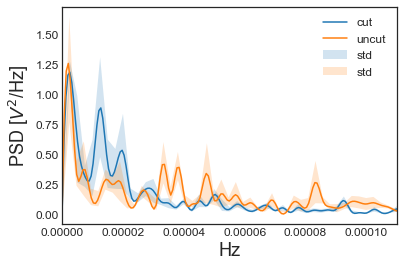

In [15]:

freq_cut=[Root_frequency_all_182,Root_frequency_all_192,Root_frequency_all_200,Root_frequency_all_208]
spd_cut=[Spectral_density_all_182,Spectral_density_all_192,Spectral_density_all_200,Spectral_density_all_208]
Averaged_Spectral_Density(spd_cut,freq_cut) #plot the cut roots

print('\n uncut: ')

#uncut roots
freq_uncut=[Root_frequency_all_142,Root_frequency_all_147,Root_frequency_all_218,Root_frequency_all_219]
spd_uncut=[Spectral_density_all_142,Spectral_density_all_147,Spectral_density_all_218,Spectral_density_all_219]
Averaged_Spectral_Density(spd_uncut,freq_uncut)   #plot the uncut roots

plt.xlim([0,0.00011]) 
plt.legend(['cut','uncut','std','std'])
plt.xlabel('Hz')
plt.ylabel('PSD [$V^2$/Hz]')

##### I think what we want to do mathemetically is take each one of the curves for each root periodogram, and then sample it at specific intervals, so that we can then go ahead and average them together.  

Root 182 is the longest root, so let's use the frequency spectrum from that to interpolate around

In [16]:
freq_spectrum = Root_frequency_all_182

In [17]:
interp_182 = sp.interpolate.interp1d(Root_frequency_all_182, Spectral_density_all_182, bounds_error=False,fill_value="extrapolate")
interp_192 = sp.interpolate.interp1d(Root_frequency_all_192, Spectral_density_all_192, bounds_error=False,fill_value="extrapolate")
interp_200 = sp.interpolate.interp1d(Root_frequency_all_200, Spectral_density_all_200, bounds_error=False,fill_value="extrapolate")
interp_208 = sp.interpolate.interp1d(Root_frequency_all_208, Spectral_density_all_208, bounds_error=False,fill_value="extrapolate")



interp_142 = sp.interpolate.interp1d(Root_frequency_all_142, Spectral_density_all_142, bounds_error=False,fill_value="extrapolate")
interp_147 = sp.interpolate.interp1d(Root_frequency_all_147, Spectral_density_all_147, bounds_error=False,fill_value="extrapolate")
interp_218 = sp.interpolate.interp1d(Root_frequency_all_218, Spectral_density_all_218, bounds_error=False,fill_value="extrapolate")
interp_219 = sp.interpolate.interp1d(Root_frequency_all_219, Spectral_density_all_219, bounds_error=False,fill_value="extrapolate")

In [18]:
Spectral_density_182_all_interpolated = interp_182(freq_spectrum[0:len(Spectral_density_all_182)])
Spectral_density_192_all_interpolated = interp_192(freq_spectrum[0:len(Spectral_density_all_192)])
Spectral_density_200_all_interpolated = interp_200(freq_spectrum[0:len(Spectral_density_all_200)])
Spectral_density_208_all_interpolated = interp_208(freq_spectrum[0:len(Spectral_density_all_208)])

Spectral_density_142_all_interpolated = interp_142(freq_spectrum[0:len(Spectral_density_all_142)])
Spectral_density_147_all_interpolated = interp_147(freq_spectrum[0:len(Spectral_density_all_147)])
Spectral_density_218_all_interpolated = interp_218(freq_spectrum[0:len(Spectral_density_all_218)])
Spectral_density_219_all_interpolated = interp_219(freq_spectrum[0:len(Spectral_density_all_219)])


#### check that the root frequenices are the same for different roots

In [19]:
Root_frequency_all_182[0:5]  #check that the root frequenices are the same for different roots

array([0.00000000e+00, 2.50247748e-06, 5.00495495e-06, 7.50743243e-06,
       1.00099099e-05])

In [20]:
Root_frequency_all_192[0:5] #check that the root frequenices are the same for different roots

array([0.00000000e+00, 2.98682796e-06, 5.97365591e-06, 8.96048387e-06,
       1.19473118e-05])

#### Ok this works.  Can roll this out for all the roots 

223
187
160
128
128

 uncut: 
223
223
145
145
145


(array([0.00000000e+00, 2.50247748e-06, 5.00495495e-06, 7.50743243e-06,
        1.00099099e-05, 1.25123874e-05, 1.50148649e-05, 1.75173423e-05,
        2.00198198e-05, 2.25222973e-05, 2.50247748e-05, 2.75272523e-05,
        3.00297297e-05, 3.25322072e-05, 3.50346847e-05, 3.75371622e-05,
        4.00396396e-05, 4.25421171e-05, 4.50445946e-05, 4.75470721e-05,
        5.00495495e-05, 5.25520270e-05, 5.50545045e-05, 5.75569820e-05,
        6.00594595e-05, 6.25619369e-05, 6.50644144e-05, 6.75668919e-05,
        7.00693694e-05, 7.25718468e-05, 7.50743243e-05, 7.75768018e-05,
        8.00792793e-05, 8.25817568e-05, 8.50842342e-05, 8.75867117e-05,
        9.00891892e-05, 9.25916667e-05, 9.50941441e-05, 9.75966216e-05,
        1.00099099e-04, 1.02601577e-04, 1.05104054e-04, 1.07606532e-04,
        1.10109009e-04, 1.12611486e-04, 1.15113964e-04, 1.17616441e-04,
        1.20118919e-04, 1.22621396e-04, 1.25123874e-04, 1.27626351e-04,
        1.30128829e-04, 1.32631306e-04, 1.35133784e-04, 1.376362

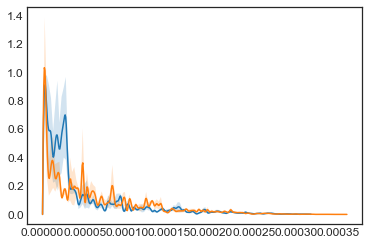

In [21]:
freq_cut=[freq_spectrum[0:len(Spectral_density_all_182)],freq_spectrum[0:len(Spectral_density_all_192)],freq_spectrum[0:len(Spectral_density_all_200)],freq_spectrum[0:len(Spectral_density_all_208)]]
spd_cut=[Spectral_density_182_all_interpolated,Spectral_density_192_all_interpolated,Spectral_density_200_all_interpolated,Spectral_density_208_all_interpolated]
Averaged_Spectral_Density(spd_cut,freq_cut) #plot the cut roots

print('\n uncut: ')

#uncut roots
freq_uncut=[freq_spectrum[0:len(Spectral_density_all_142)],freq_spectrum[0:len(Spectral_density_all_147)],freq_spectrum[0:len(Spectral_density_all_218)],freq_spectrum[0:len(Spectral_density_all_219)]]
spd_uncut=[Spectral_density_142_all_interpolated,Spectral_density_147_all_interpolated,Spectral_density_218_all_interpolated,Spectral_density_219_all_interpolated]
Averaged_Spectral_Density(spd_uncut,freq_uncut)   #plot the uncut roots



###  Find the peaks in the data

223
187
160
128
128
223
223
145
145
145


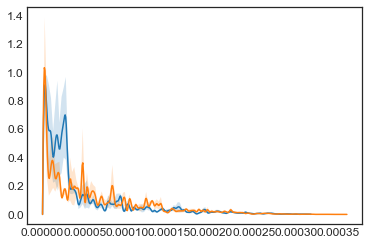

In [22]:
frequency_of_psd_cut,mean_spd_cut,std_cut = Averaged_Spectral_Density(spd_cut,freq_cut)
frequency_of_psd_uncut,mean_spd_uncut,std_uncut = Averaged_Spectral_Density(spd_uncut,freq_uncut)


In [23]:
#Uncut peaks
peaks_uncut, _ = find_peaks(mean_spd_uncut, height=0, prominence=0.075)
peak_frequencies_uncut = frequency_of_psd_uncut[peaks_uncut]
peak_frequencies_uncut #frequency locations of the uncut peaks
peaks_in_seconds_uncut=peak_frequencies_uncut**-1
peaks_in_hours_uncut = peaks_in_seconds_uncut/3600
peaks_in_hours_uncut

array([111.00111001,  22.200222  ,   8.53854692,   5.84216368,
         5.28576714,   3.36367   ,   2.26532878])

In [24]:
#Cut peaks
peaks_cut, _ = find_peaks(mean_spd_cut, height=0.0, prominence=0.075)
peak_frequencies_cut = frequency_of_psd_cut[peaks_cut]
peak_frequencies_cut #frequency loation of the cut peaks
peaks_in_seconds_cut=peak_frequencies_cut**-1
peaks_in_hours_cut = peaks_in_seconds_cut/3600
peaks_in_hours_cut

array([111.00111001,  15.85730143,  10.09101   ,   3.00003   ])

## Plot peaks on graph

In [25]:
def smoothed_spectral_density(Frequency,spectral_density): 
  
  
  std=np.std(spectral_density,axis=0)/2 #determines the standard deviation of the spectrum, divided by 2

  #plt.plot(frequency_of_psd,mean_spd)
  f2 = interp1d(Frequency, spectral_density, kind='quadratic')
  x=np.linspace(0, Frequency[-1], num=5000, endpoint=True)
    
    
  plt.plot(x[1:],f2(x)[1:])
  plt.fill_between(Frequency, f2(Frequency)-std, f2(Frequency)+std,
    alpha=0.2,
    linewidth=4, linestyle='dashdot', antialiased=True)

  return x, f2(x) #return the new linspace and interpolated frequency space

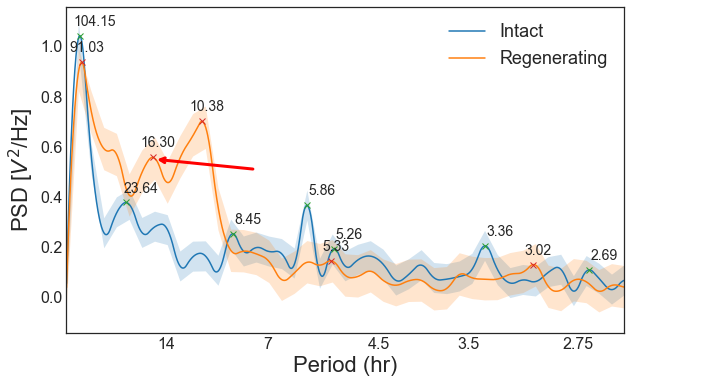

In [26]:
#Averaged_Spectral_Density(mean_spd_uncut,frequency_of_psd_uncut)
#Averaged_Spectral_Density(mean_spd_cut,frequency_of_psd_cut)
#fig, ax = plt.subplots(figsize=(10,8))
#frequency_of_psd_uncut_in_hours[0]=0
#frequency_of_psd_cut_in_hours[0]=0 

#frequency_of_psd_uncut_in_hours[1:] = (1/frequency_of_psd_uncut[1:])/3600
#frequency_of_psd_cut_in_hours[1:] = (1/frequency_of_psd_cut[1:])/3600


freq_smoothed_uncut, psd_smoothed_uncut = smoothed_spectral_density(frequency_of_psd_uncut,mean_spd_uncut)
freq_smoothed_cut, psd_smoothed_cut = smoothed_spectral_density(frequency_of_psd_cut,mean_spd_cut)



#Uncut peaks
peaks_uncut, _ = find_peaks(psd_smoothed_uncut, height=0, prominence=0.075)
peak_frequencies_uncut = freq_smoothed_uncut[peaks_uncut]
peak_frequencies_uncut #frequency locations of the uncut peaks
peaks_in_seconds_uncut=peak_frequencies_uncut**-1
peaks_in_hours_uncut = peaks_in_seconds_uncut/3600
peaks_in_hours_uncut

#Cut peaks
peaks_cut, _ = find_peaks(psd_smoothed_cut, height=0.0, prominence=0.075)
peak_frequencies_cut = freq_smoothed_cut[peaks_cut]
peak_frequencies_cut #frequency loation of the cut peaks
peaks_in_seconds_cut=peak_frequencies_cut**-1
peaks_in_hours_cut = peaks_in_seconds_cut/3600
peaks_in_hours_cut

##Turn x into hours
#frequency_of_psd_uncut_in_hours[1:] = (1/frequency_of_psd_uncut[1:])/3600
#frequency_of_psd_cut_in_hours[1:] = (1/frequency_of_psd_cut[1:])/3600
#frequency_of_psd_uncut_in_hours[0]=0  #clear the divide by zero error
#frequency_of_psd_cut_in_hours[0]=0   #clear the divide by zero error



#plt.plot(frequency_of_psd_uncut,mean_spd_uncut)
#plt.plot(frequency_of_psd_cut,mean_spd_cut)
fig = plt.gcf()
fig.set_size_inches(10,6)


x_min = (1/(64*3900))


#positions = freq_smoothed_uncut
#labels = frequency_of_psd_uncut_in_hours

positions = [0.0000198
, 0.0000397
, 0.0000617, 0.0000794, 0.000101]
labels = ['14', '7', '4.5', '3.5', '2.75']

plt.xticks(positions, labels, fontsize=16)
plt.yticks(fontsize=16)
plt.xlim([0,0.00011]) 
plt.legend(['Intact', 'Regenerating'], fontsize=18)
plt.xlabel('Period (hr)', fontsize=22)
plt.ylabel('PSD [$V^2$/Hz]', fontsize=22)
plt.plot(peak_frequencies_uncut, psd_smoothed_uncut[peaks_uncut], "x")


x=0
for point in peaks_uncut:
    
    plt.annotate(str("{:.2f}".format(peaks_in_hours_uncut[x])), # this is the text
                (freq_smoothed_uncut[point],psd_smoothed_uncut[point]), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(15,10), # distance from text to points (x,y)
                ha='center', 
                fontsize=14) # horizontal alignment can be left, right or center
    x=x+1
    
plt.plot(peak_frequencies_cut, psd_smoothed_cut[peaks_cut], "x")
#
x=0
for point in peaks_cut:
#    
    plt.annotate(str("{:.2f}".format(peaks_in_hours_cut[x])), # this is the text
                (freq_smoothed_cut[point],psd_smoothed_cut[point]), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(5,10), # distance from text to points (x,y)
                ha='center',
                fontsize=14) # horizontal alignment can be left, right or center
    x=x+1

plt.annotate("", xy=(0.0000175,0.55), xytext=(100,-10),textcoords='offset points',
arrowprops=dict(arrowstyle="->",connectionstyle="arc3",color="red", lw=3))


plt.show()
fig.savefig('Periodogram_Feb_2022.png', dpi=600)
fig.savefig('Periodogram_Feb_2022.pdf', dpi=600)

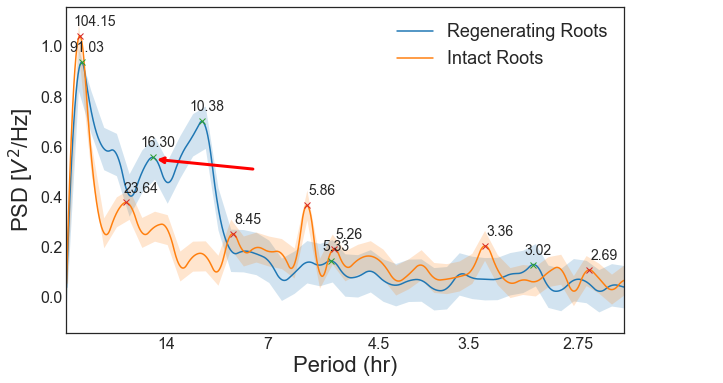

In [27]:
#JUST SWAPPING THE COLORS


#Averaged_Spectral_Density(mean_spd_uncut,frequency_of_psd_uncut)
#Averaged_Spectral_Density(mean_spd_cut,frequency_of_psd_cut)
#fig, ax = plt.subplots(figsize=(10,8))
#frequency_of_psd_uncut_in_hours[0]=0
#frequency_of_psd_cut_in_hours[0]=0 

#frequency_of_psd_uncut_in_hours[1:] = (1/frequency_of_psd_uncut[1:])/3600
#frequency_of_psd_cut_in_hours[1:] = (1/frequency_of_psd_cut[1:])/3600

freq_smoothed_cut, psd_smoothed_cut = smoothed_spectral_density(frequency_of_psd_cut,mean_spd_cut)
freq_smoothed_uncut, psd_smoothed_uncut = smoothed_spectral_density(frequency_of_psd_uncut,mean_spd_uncut)




#Uncut peaks
peaks_uncut, _ = find_peaks(psd_smoothed_uncut, height=0, prominence=0.075)
peak_frequencies_uncut = freq_smoothed_uncut[peaks_uncut]
peak_frequencies_uncut #frequency locations of the uncut peaks
peaks_in_seconds_uncut=peak_frequencies_uncut**-1
peaks_in_hours_uncut = peaks_in_seconds_uncut/3600
peaks_in_hours_uncut

#Cut peaks
peaks_cut, _ = find_peaks(psd_smoothed_cut, height=0.0, prominence=0.075)
peak_frequencies_cut = freq_smoothed_cut[peaks_cut]
peak_frequencies_cut #frequency loation of the cut peaks
peaks_in_seconds_cut=peak_frequencies_cut**-1
peaks_in_hours_cut = peaks_in_seconds_cut/3600
peaks_in_hours_cut

##Turn x into hours
#frequency_of_psd_uncut_in_hours[1:] = (1/frequency_of_psd_uncut[1:])/3600
#frequency_of_psd_cut_in_hours[1:] = (1/frequency_of_psd_cut[1:])/3600
#frequency_of_psd_uncut_in_hours[0]=0  #clear the divide by zero error
#frequency_of_psd_cut_in_hours[0]=0   #clear the divide by zero error



#plt.plot(frequency_of_psd_uncut,mean_spd_uncut)
#plt.plot(frequency_of_psd_cut,mean_spd_cut)
fig = plt.gcf()
fig.set_size_inches(10,6)


x_min = (1/(64*3900))


#positions = freq_smoothed_uncut
#labels = frequency_of_psd_uncut_in_hours

positions = [0.0000198
, 0.0000397
, 0.0000617, 0.0000794, 0.000101]
labels = ['14', '7', '4.5', '3.5', '2.75']

plt.xticks(positions, labels, fontsize=16)
plt.yticks(fontsize=16)
plt.xlim([0,0.00011]) 
plt.legend(['Regenerating Roots', 'Intact Roots'], fontsize=18)
plt.xlabel('Period (hr)', fontsize=22)
plt.ylabel('PSD [$V^2$/Hz]', fontsize=22)
#####
plt.plot(peak_frequencies_cut, psd_smoothed_cut[peaks_cut], "x")
#
x=0
for point in peaks_cut:
#    
    plt.annotate(str("{:.2f}".format(peaks_in_hours_cut[x])), # this is the text
                (freq_smoothed_cut[point],psd_smoothed_cut[point]), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(5,10), # distance from text to points (x,y)
                ha='center',
                fontsize=14) # horizontal alignment can be left, right or center
    x=x+1

plt.annotate("", xy=(0.0000175,0.55), xytext=(100,-10),textcoords='offset points',
arrowprops=dict(arrowstyle="->",connectionstyle="arc3",color="red", lw=3))


######
plt.plot(peak_frequencies_uncut, psd_smoothed_uncut[peaks_uncut], "x")


x=0
for point in peaks_uncut:
    
    plt.annotate(str("{:.2f}".format(peaks_in_hours_uncut[x])), # this is the text
                (freq_smoothed_uncut[point],psd_smoothed_uncut[point]), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(15,10), # distance from text to points (x,y)
                ha='center', 
                fontsize=14) # horizontal alignment can be left, right or center
    x=x+1
######    

######
plt.show()
fig.savefig('Periodogram_July_2023.png', dpi=600)
fig.savefig('Periodogram_July_2023.pdf', dpi=600)